<a href="https://colab.research.google.com/github/JorgeAndreu1/tiktok-jhsj36agfa4.github.io/blob/main/TSP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
!git clone https://github.com/RobInLabUJI/Pyevolve

fatal: destination path 'Pyevolve' already exists and is not an empty directory.


In [65]:
import sys
sys.path.append('/content/Pyevolve')

In [66]:

import collections
collections.Callable = collections.abc.Callable

In [67]:
!mkdir -p tspimg

# The Travelling Salesperson Problem

This notebook has been adapted from [a Pyevolve example](http://pyevolve.sourceforge.net/0_6rc1/examples.html#example-12-the-travelling-salesman-problem-tsp).

The [travelling salesperson problem (TSP)](http://en.wikipedia.org/wiki/Travelling_salesman_problem) is an NP-hard problem in combinatorial optimization studied in operations research and theoretical computer science. Given a list of cities and their pairwise distances, the task is to find the shortest possible route that visits each city exactly once and returns to the origin city. It is a special case of the travelling purchaser problem.

[<img src="https://github.com/RobInLabUJI/GeneticAlgorithm/raw/main/img/travelling_salesman_problem.jpg" align="right" width=360>](http://en.wikipedia.org/wiki/Travelling_salesman_problem)

The code below shows the use of Pyevolve to solve the TSP. Images of the intermediate and final solutions are stored in the 'tspimg' folder.

Your tasks are:
1. Create the 'tspimg' folder for storing the images.
2. Add the necessary statements for storing the results in a database named 'tsp.db' with identifier 'ex1'.
3. For the maximum grade: modify the code to solve the problem with the [ATT 48 dataset](https://github.com/RobInLabUJI/GeneticAlgorithm/raw/main/att48.tsp),  a set of 48 cities (US state capitals) from [TSPLIB](http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/). Store the results in a database named 'tsp_att48.db' with identifier 'ex1'. For your information, [the optimal cost is 10628](http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/STSP.html).

In [68]:
from pyevolve import G1DList
from pyevolve import GSimpleGA
from pyevolve import Crossovers
from pyevolve import Consts
from pyevolve import DBAdapters


import random
from math import sqrt
from PIL import Image, ImageDraw, ImageFont

In [69]:
cm     = []
coords = []
CITIES = 30
WIDTH   = 600
HEIGHT  = 400
LAST_SCORE = -1

In [70]:
def cartesian_matrix(coords):
    """ A distance matrix """
    matrix={}
    for i,(x1,y1) in enumerate(coords):
        for j,(x2,y2) in enumerate(coords):
            dx, dy = x1-x2, y1-y2
            dist=sqrt(dx*dx + dy*dy)
            matrix[i,j] = dist
    return matrix

In [71]:
def tour_length(matrix, tour):
    """ Returns the total length of the tour """
    total = 0
    t = tour.getInternalList()
    for i in range(CITIES):
        j      = (i+1)%CITIES
        total += matrix[t[i], t[j]]
    return total

In [72]:
def write_tour_to_img(coords, tour, img_file):
    """ The function to plot the graph """
    padding=20
    coords=[(x+padding,y+padding) for (x,y) in coords]
    maxx,maxy=0,0
    for x,y in coords:
        maxx, maxy = max(x,maxx), max(y,maxy)
    maxx+=padding
    maxy+=padding
    img=Image.new("RGB",(int(maxx),int(maxy)),color=(255,255,255))
    font=ImageFont.load_default()
    d=ImageDraw.Draw(img);
    num_cities=len(tour)
    for i in range(num_cities):
        j=(i+1)%num_cities
        city_i=tour[i]
        city_j=tour[j]
        x1,y1=coords[city_i]
        x2,y2=coords[city_j]
        d.line((int(x1),int(y1),int(x2),int(y2)),fill=(0,0,0))
        d.text((int(x1)+7,int(y1)-5),str(i),font=font,fill=(32,32,32))

    for x,y in coords:
        x,y=int(x),int(y)
        d.ellipse((x-5,y-5,x+5,y+5),outline=(0,0,0),fill=(196,196,196))
    del d
    img.save(img_file, "PNG")
    print ("The plot was saved into the %s file." % (img_file,))

In [73]:
def G1DListTSPInitializator(genome, **args):
    """ The initializator for the TSP """
    lst = [i for i in range(genome.getListSize())]
    random.shuffle(lst)
    genome.setInternalList(lst)

In [74]:
def evolve_callback(ga_engine):
    global LAST_SCORE
    if ga_engine.getCurrentGeneration() % 100 == 0:
        best = ga_engine.bestIndividual()
        if LAST_SCORE != best.getRawScore():
            write_tour_to_img( coords, best, "tspimg/tsp_result_%05d.png" % ga_engine.getCurrentGeneration())
            LAST_SCORE = best.getRawScore()
    return False

In [75]:
coords = [(random.randint(0, WIDTH), random.randint(0, HEIGHT))
             for i in range(CITIES)]
cm     = cartesian_matrix(coords)

In [76]:
genome = G1DList.G1DList(len(coords))
genome.evaluator.set(lambda chromosome: tour_length(cm, chromosome))
genome.crossover.set(Crossovers.G1DListCrossoverEdge)
genome.initializator.set(G1DListTSPInitializator)

In [77]:
sqlite_adapter = DBAdapters.DBSQLite(dbname='tsp.db', identify='ex1', resetDB=True)

In [78]:
ga = GSimpleGA.GSimpleGA(genome)
ga.setGenerations(2000)
ga.setMinimax(Consts.minimaxType["minimize"])
ga.setCrossoverRate(1.0)
ga.setMutationRate(0.02)
ga.setPopulationSize(80)
ga.stepCallback.set(evolve_callback)
ga.setDBAdapter(sqlite_adapter)

In [79]:
ga.evolve(freq_stats=200)
best = ga.bestIndividual()
write_tour_to_img(coords, best, "tspimg/tsp_result.png")

The plot was saved into the tspimg/tsp_result_00000.png file.
Gen. 0 (0.00%): Max/Min/Avg Fitness(Raw)             [8821.07(8737.51)/5369.82(5482.41)/7350.89(7350.89)]
The plot was saved into the tspimg/tsp_result_00100.png file.
The plot was saved into the tspimg/tsp_result_00200.png file.
Gen. 200 (10.00%): Max/Min/Avg Fitness(Raw)             [4176.89(4846.33)/2984.29(2506.88)/3480.74(3480.74)]
The plot was saved into the tspimg/tsp_result_00300.png file.
The plot was saved into the tspimg/tsp_result_00400.png file.
Gen. 400 (20.00%): Max/Min/Avg Fitness(Raw)             [3840.54(5951.58)/3003.10(2352.25)/3200.45(3200.45)]
The plot was saved into the tspimg/tsp_result_00500.png file.
The plot was saved into the tspimg/tsp_result_00600.png file.
Gen. 600 (30.00%): Max/Min/Avg Fitness(Raw)             [3925.70(5902.05)/3037.65(2331.52)/3271.41(3271.41)]
Gen. 800 (40.00%): Max/Min/Avg Fitness(Raw)             [3818.32(4442.00)/2752.44(2331.52)/3181.93(3181.93)]
Gen. 1000 (50.00%): Max/

You can check now the results by plotting some graphs of the evolution process in [this notebook](https://github.com/RobInLabUJI/GeneticAlgorithm/blob/main/TSP_check.ipynb).

In [80]:
import sys
sys.path.append('/content/Pyevolve')

In [81]:
!wget https://github.com/RobInLabUJI/GeneticAlgorithm/raw/main/pyevolve_plot.py

--2025-04-24 10:13:45--  https://github.com/RobInLabUJI/GeneticAlgorithm/raw/main/pyevolve_plot.py
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/RobInLabUJI/GeneticAlgorithm/main/pyevolve_plot.py [following]
--2025-04-24 10:13:46--  https://raw.githubusercontent.com/RobInLabUJI/GeneticAlgorithm/main/pyevolve_plot.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10520 (10K) [text/plain]
Saving to: ‘pyevolve_plot.py.2’

pyevolve_plot.py.2  100%[===================>]  10.27K  --.-KB/s    in 0.001s  

2025-04-24 10:13:46 (14.7 MB/s) - ‘pyevolve_plot.py.2’ saved [10520/10520]



# The Travelling Salesperson Problem

## Plots

Plot the following graphs of the evolution process:
* Error bars graph (raw scores).
* Error bars graph (fitness scores).
* Max/min/avg/std. dev. graph (raw scores).
* Max/min/avg/std. dev. graph (fitness scores).
* Raw and Fitness min/max difference graph.

In [82]:
%matplotlib inline
from pyevolve_plot import plot_errorbars_raw, plot_errorbars_fitness, \
                          plot_maxmin_raw, plot_maxmin_fitness, \
                          plot_diff_raw, plot_pop_heatmap_raw

Loading database...
2000 generations found !


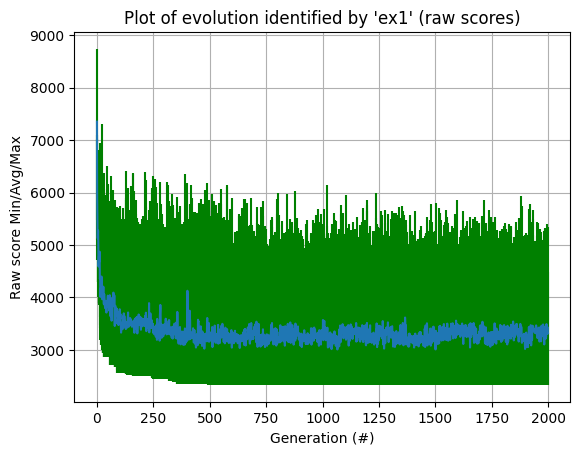

In [83]:
plot_errorbars_raw('tsp.db','ex1')

Loading database...
2000 generations found !


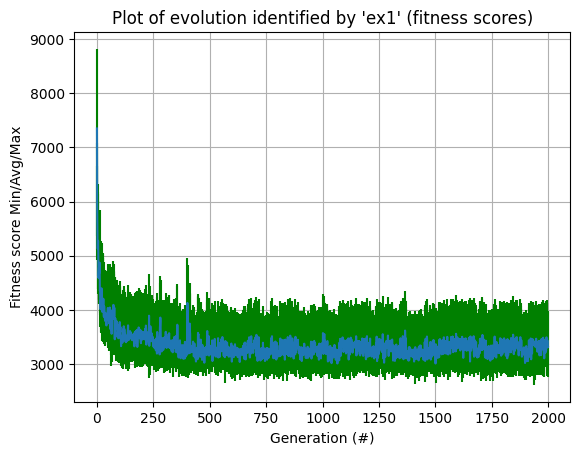

In [84]:
plot_errorbars_fitness('tsp.db','ex1')

Loading database...
2000 generations found !


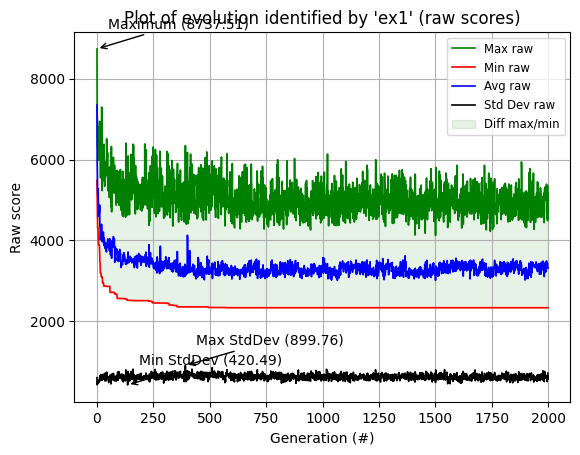

In [85]:
plot_maxmin_raw('tsp.db','ex1')

Loading database...
2000 generations found !


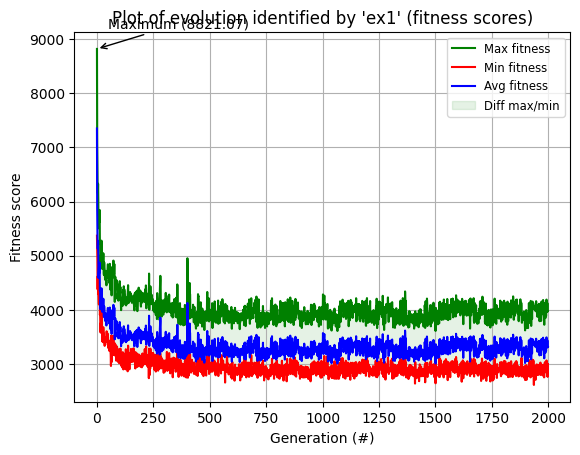

In [86]:
plot_maxmin_fitness('tsp.db','ex1')

Loading database...
2000 generations found !


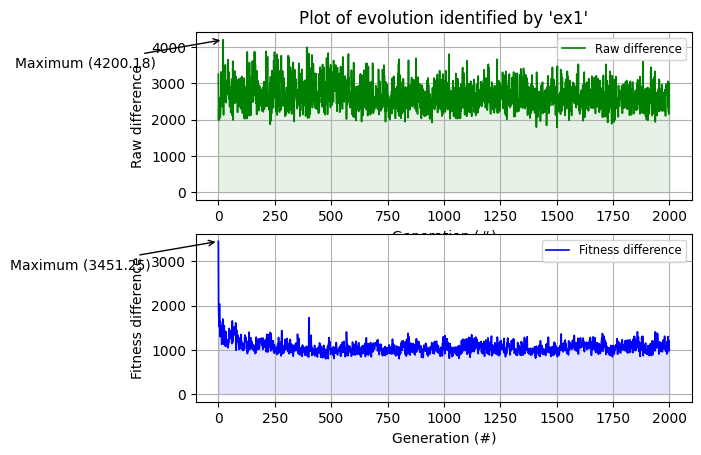

In [87]:
plot_diff_raw('tsp.db','ex1')

## Route images

Plot the images of the routes stored in the 'tspimg' folder.

In [88]:
import matplotlib.pyplot as plt
from PIL import Image

In [89]:
import glob
images = glob.glob("tsp_result_*.png")

In [90]:
for im in images:
    tsp_result = Image.open(im)
    print("Generation %d" % int(im[18:-4]))
    plt.imshow(tsp_result)
    plt.show()

Final best individual


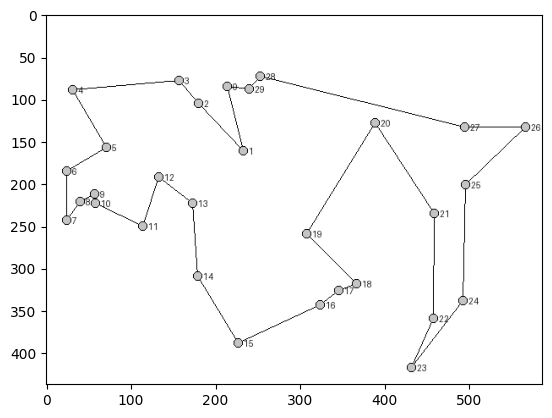

In [91]:
print('Final best individual')
tsp_result = Image.open('tspimg/tsp_result.png')
plt.imshow(tsp_result);

In [92]:
! rm -r "tspimg/tsp_result*.png"

rm: cannot remove 'tspimg/tsp_result*.png': No such file or directory
